It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb).
<table align="center">
 <td align="center"><a target="_blank" href="https://colab.research.google.com/github/ezponda/intro_deep_learning/blob/main/class/Fundamentals/NN_Fundamentals.ipynb">
        <img src="https://colab.research.google.com/img/colab_favicon_256px.png"  width="50" height="50" style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/ezponda/intro_deep_learning/blob/main/class/Fundamentals/NN_Fundamentals.ipynb">
        <img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png"  width="50" height="50" style="padding-bottom:5px;" />View Source on GitHub</a></td>
</table>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib.pyplot as plt
%matplotlib inline

tf.random.set_seed(0)

In [2]:

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    h = 0.05
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:,0], X[:,1], c=y.ravel(), cmap=plt.cm.Spectral)

def load_planar_dataset(m, sigma=0.2):
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*sigma # theta
        r = a*np.sin(4*t) + np.random.randn(N)*sigma # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    ## premuting ouput
    p = np.random.permutation(m)
    X = X[p,:]
    Y = Y[p,:]

    return X, Y.ravel()

def draw_neural_net(left, right, bottom, top, layer_sizes):
    '''
    From https://gist.github.com/craffel/2d727968c3aaebd10359#file-draw_neural_net-py
    Draw a neural network cartoon using matplotilb.

    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])

    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    fig = plt.figure(figsize=(3, 3))
    ax = fig.gca()
    ax.axis('off')

    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

## Dataset

We have a binary classification dataset. The target `y` has two possible values, {0,1} and the input vector `x` has two dimensions.

In [3]:
N = 5000
X, y = load_planar_dataset(N, 0.2)

Visualize the dataset using matplotlib. The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. Your goal is to build a model to fit this data.

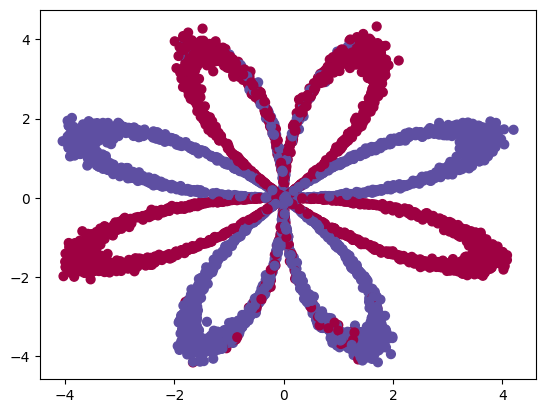

In [4]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [5]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.2,
)

In [6]:
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(4000, 2), y_train shape:(4000,)
X_test shape:(1000, 2), y_test shape:(1000,)


In [11]:
## X first example
X[0,:] # las X's van a ser las coordenadas en el plano

array([-1.4950703 ,  3.57467016])

In [12]:
## Y firsts examples. Las y's van a ser 0's y 1's dependiendo de la clase en la que estén
y[:8]

array([0, 1, 0, 1, 1, 1, 0, 1], dtype=uint8)

## First NN in Keras

### Logistic regression

Fully connected layers are defined using the [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) class. We can specify the number of neurons as the first argument, and specify the activation function using the activation argument.

```python
tf.keras.layers.Dense(
    units, activation=None
)

```

- **units**: Number of neurons in the layer.
- **activation**: Activation function to use, default function is `linear`, you can also use `sigmoid` for sigmoid activation or [other alternatives](https://www.tensorflow.org/api_docs/python/tf/keras/activations)

For defining the input layer you can use `keras.Input(shape=(input_dimension,))` or define your input dimension in the first hidden layer.

```python
layers.Dense(4, activation="sigmoid", input_shape=(input_dimension,))

```

Build a network without hidden layer

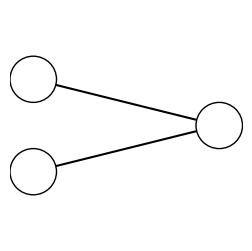

In [13]:
draw_neural_net(.1, .9, .1, .9, [2, 1])

In [18]:
model = keras.Sequential() # creamos el modelo vacío y luego vamos añadiendo capas con model.add()
# The dimension of the input is 2 (planar data)
# we have only one output layer with 1 neuron
model.add(keras.layers.Dense(1, input_shape=(2, ), activation='sigmoid')) # Para problemas de clasificación binaria, la última capa debe ser una sigmoide

In [19]:
model.summary() # muestra los parámetros del modelo

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 3 (12.00 Byte)
Trainable params: 3 (12.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


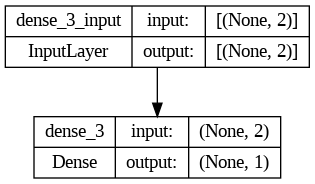

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

#### Compile
Now we need to specify the loss function, the metrics and the optimizer. It is done using compile function in Keras.

In [22]:
model.compile( # lo dejamos predefinido y lo vemos en los siguientes vídeos
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#### Training model
This is similar to a sklearn model.

In [23]:
model.fit(X_train, y_train, epochs=10, # epochs es el número de veces que recorre el dataset
          validation_split=0.2, batch_size=32)

Epoch 1/10
100/100 [==============================] - 1s 5ms/step - loss: 0.9014 - accuracy: 0.5050 - val_loss: 0.8706 - val_accuracy: 0.4950
Epoch 2/10
100/100 [==============================] - 0s 3ms/step - loss: 0.8400 - accuracy: 0.5219 - val_loss: 0.8159 - val_accuracy: 0.5300
Epoch 3/10
100/100 [==============================] - 0s 2ms/step - loss: 0.7916 - accuracy: 0.5475 - val_loss: 0.7736 - val_accuracy: 0.5525
Epoch 4/10
100/100 [==============================] - 0s 2ms/step - loss: 0.7539 - accuracy: 0.5831 - val_loss: 0.7410 - val_accuracy: 0.5813
Epoch 5/10
100/100 [==============================] - 0s 2ms/step - loss: 0.7254 - accuracy: 0.6200 - val_loss: 0.7165 - val_accuracy: 0.6313
Epoch 6/10
100/100 [==============================] - 0s 2ms/step - loss: 0.7041 - accuracy: 0.6662 - val_loss: 0.6991 - val_accuracy: 0.6787
Epoch 7/10
100/100 [==============================] - 0s 3ms/step - loss: 0.6888 - accuracy: 0.6884 - val_loss: 0.6864 - val_accuracy: 0.6762
Epoch 

#### Making predictions

In [24]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.670148491859436
Test Accuracy: 0.5490000247955322


In [25]:
y_pred = model.predict(X_test)
y_pred[:3], y_test[:3]

32/32 [==============================] - 0s 1ms/step


(array([[0.55773294],
        [0.40104088],
        [0.4213795 ]], dtype=float32),
 array([0, 1, 0], dtype=uint8))

1282/1282 [==============================] - 4s 3ms/step


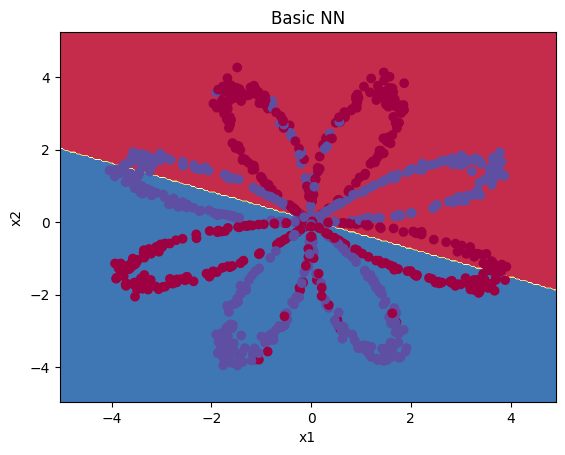

In [27]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("Basic NN"); # al solo tener una capa, solo puede aprender una recta

### One hidden layer NN

- One **input with 2 features (input_shape)**
- **One hidden dense layer**,  with **3 neurons** and implemented with  **sigmoid activating function**
- **One Output** (sigmoid output activation function)

We can create layers incrementally with the method `add()`:

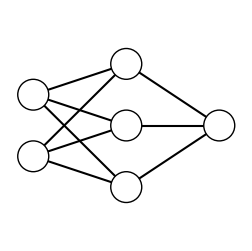

In [28]:
draw_neural_net(.1, .9, .1, .9, [2, 3, 1])

In [29]:
model = keras.Sequential()

## hidden layer with 3 neurons and sigmoid activation
## The first layer need to have the input_shape
model.add(layers.Dense(3, input_shape=(2,), activation='sigmoid'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

## model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 3)                 9         
                                                                 
 dense_5 (Dense)             (None, 1)                 4         
                                                                 
Total params: 13 (52.00 Byte)
Trainable params: 13 (52.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


You can also define the model with a list of layers
```python
model = keras.Sequential([
    keras.Input(shape=(2, )),
    layers.Dense(3, activation='sigmoid', name='layer1'),
    layers.Dense(1, activation='sigmoid', name='layer3')
])
````

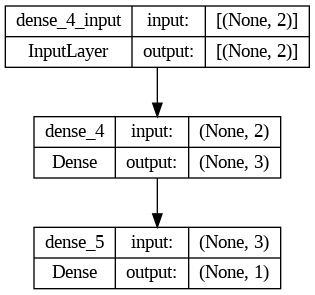

In [30]:
plot_model(model, show_shapes=True)

In [31]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 [==============================] - 2s 9ms/step - loss: 0.9236 - accuracy: 0.5000 - val_loss: 0.8833 - val_accuracy: 0.4963
Epoch 2/25
100/100 [==============================] - 0s 2ms/step - loss: 0.8419 - accuracy: 0.5000 - val_loss: 0.8113 - val_accuracy: 0.4963
Epoch 3/25
100/100 [==============================] - 0s 3ms/step - loss: 0.7833 - accuracy: 0.5000 - val_loss: 0.7617 - val_accuracy: 0.4963
Epoch 4/25
100/100 [==============================] - 0s 2ms/step - loss: 0.7430 - accuracy: 0.5000 - val_loss: 0.7290 - val_accuracy: 0.4963
Epoch 5/25
100/100 [==============================] - 0s 2ms/step - loss: 0.7162 - accuracy: 0.5000 - val_loss: 0.7073 - val_accuracy: 0.4963
Epoch 6/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6990 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.4963
Epoch 7/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6877 - accuracy: 0.5056 - val_loss: 0.6847 - val_accuracy: 0.5375
Epoch 

In [32]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.6356328129768372
Test Accuracy: 0.5350000262260437


1282/1282 [==============================] - 7s 6ms/step


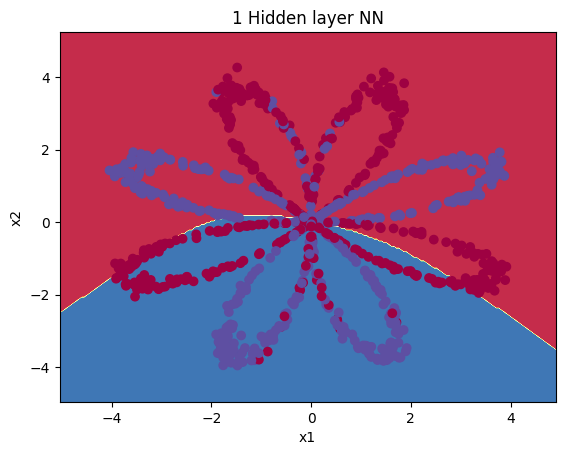

In [34]:
plot_decision_boundary(lambda x: ( # con esto representamos la curva de decisión del modelo
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN");

### Question 1:
####  What happens if we change the activation function of the first hidden  layer to `'linear'`?

In [35]:
model = keras.Sequential()
## The first layer need to have the input_shape
## change the activation function

model.add(layers.Dense(3, input_shape=(2,), activation= 'linear'))
# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [39]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 [==============================] - 1s 6ms/step - loss: 0.6590 - accuracy: 0.4822 - val_loss: 0.6637 - val_accuracy: 0.4525
Epoch 2/25
100/100 [==============================] - 0s 5ms/step - loss: 0.6590 - accuracy: 0.4787 - val_loss: 0.6640 - val_accuracy: 0.4550
Epoch 3/25
100/100 [==============================] - 0s 4ms/step - loss: 0.6589 - accuracy: 0.4837 - val_loss: 0.6639 - val_accuracy: 0.4512
Epoch 4/25
100/100 [==============================] - 1s 6ms/step - loss: 0.6589 - accuracy: 0.4678 - val_loss: 0.6638 - val_accuracy: 0.4500
Epoch 5/25
100/100 [==============================] - 0s 4ms/step - loss: 0.6590 - accuracy: 0.4716 - val_loss: 0.6639 - val_accuracy: 0.4500
Epoch 6/25
100/100 [==============================] - 1s 5ms/step - loss: 0.6590 - accuracy: 0.4806 - val_loss: 0.6638 - val_accuracy: 0.4500
Epoch 7/25
100/100 [==============================] - 0s 4ms/step - loss: 0.6589 - accuracy: 0.4778 - val_loss: 0.6638 - val_accuracy: 0.4475
Epoch 

**Loss**: it can be seen as a distance between the true values of the problem and the values predicted by the model. The larger the loss, the larger the errors you made on the data.

**Accuracy**: it can be seen as the count of mistakes/misclassifications you made on the data. The larger the accuracy, the fewer misclassifications you made on the data.

Test Loss: 0.6666585206985474
Test Accuracy: 0.4410000145435333
1282/1282 [==============================] - 2s 1ms/step


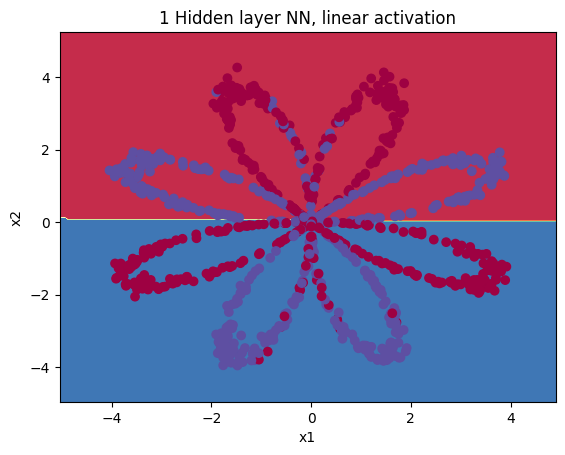

In [40]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

Poner una capa linear es como si no pusieras nada, como una regresión logística

### Question 2:
####  What happens if we add more neurons to the first hidden layer ?

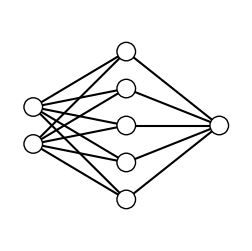

In [41]:
draw_neural_net(.1, .9, .1, .9, [2, 5, 1])

In [56]:
model = keras.Sequential()

## The first layer need to have the input_shape
## set the number of neurons
model.add(layers.Dense(5, input_shape=(2,), activation='sigmoid')) # ponemos 5 por el vídeo, aunque funciona mejor con 4

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [57]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 [==============================] - 1s 4ms/step - loss: 0.9346 - accuracy: 0.5000 - val_loss: 0.8570 - val_accuracy: 0.5038
Epoch 2/25
100/100 [==============================] - 0s 3ms/step - loss: 0.8259 - accuracy: 0.5000 - val_loss: 0.7765 - val_accuracy: 0.5038
Epoch 3/25
100/100 [==============================] - 0s 2ms/step - loss: 0.7549 - accuracy: 0.5000 - val_loss: 0.7273 - val_accuracy: 0.5038
Epoch 4/25
100/100 [==============================] - 0s 3ms/step - loss: 0.7139 - accuracy: 0.5000 - val_loss: 0.6998 - val_accuracy: 0.5038
Epoch 5/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6917 - accuracy: 0.5178 - val_loss: 0.6849 - val_accuracy: 0.5138
Epoch 6/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6786 - accuracy: 0.6019 - val_loss: 0.6753 - val_accuracy: 0.6525
Epoch 7/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6697 - accuracy: 0.6594 - val_loss: 0.6683 - val_accuracy: 0.6550
Epoch 

Test Loss: 0.6056954860687256
Test Accuracy: 0.5180000066757202
1282/1282 [==============================] - 2s 1ms/step


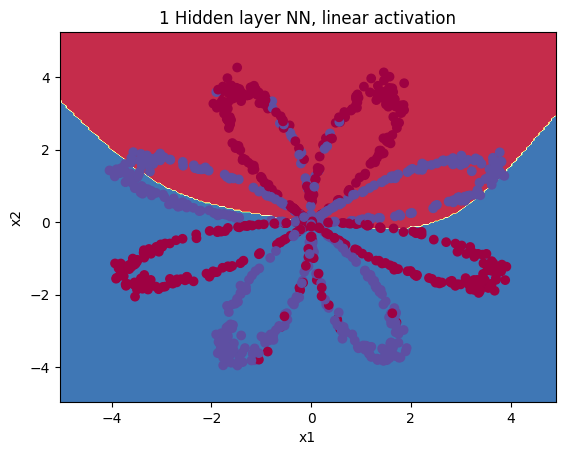

In [58]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

If we add some more layers to the model, it is able to predict better as it can make more complex figures

### Question 3:
####  What happens if we add one more hidden layer ?

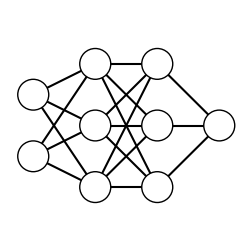

In [45]:
draw_neural_net(.1, .9, .1, .9, [2, 3, 3, 1])

In [59]:
model = keras.Sequential()
# First hidden layer (need to innclude input_shape)
## Set the number of neurons
model.add(layers.Dense(3, input_shape=(2,), activation='sigmoid'))

# second hidden layer
## Complete the code
model.add((layers.Dense(3, activation='sigmoid'))) # el input_shape solo se pone en la primera capa

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [60]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 [==============================] - 1s 5ms/step - loss: 0.7009 - accuracy: 0.5000 - val_loss: 0.6939 - val_accuracy: 0.4963
Epoch 2/25
100/100 [==============================] - 1s 6ms/step - loss: 0.6890 - accuracy: 0.4988 - val_loss: 0.6858 - val_accuracy: 0.5325
Epoch 3/25
100/100 [==============================] - 0s 4ms/step - loss: 0.6833 - accuracy: 0.6144 - val_loss: 0.6812 - val_accuracy: 0.6413
Epoch 4/25
100/100 [==============================] - 1s 5ms/step - loss: 0.6787 - accuracy: 0.6538 - val_loss: 0.6770 - val_accuracy: 0.6587
Epoch 5/25
100/100 [==============================] - 1s 5ms/step - loss: 0.6743 - accuracy: 0.6778 - val_loss: 0.6727 - val_accuracy: 0.6775
Epoch 6/25
100/100 [==============================] - 0s 5ms/step - loss: 0.6699 - accuracy: 0.6822 - val_loss: 0.6684 - val_accuracy: 0.6800
Epoch 7/25
100/100 [==============================] - 1s 7ms/step - loss: 0.6652 - accuracy: 0.6850 - val_loss: 0.6639 - val_accuracy: 0.6737
Epoch 

Test Loss: 0.6020212173461914
Test Accuracy: 0.625
1282/1282 [==============================] - 2s 2ms/step


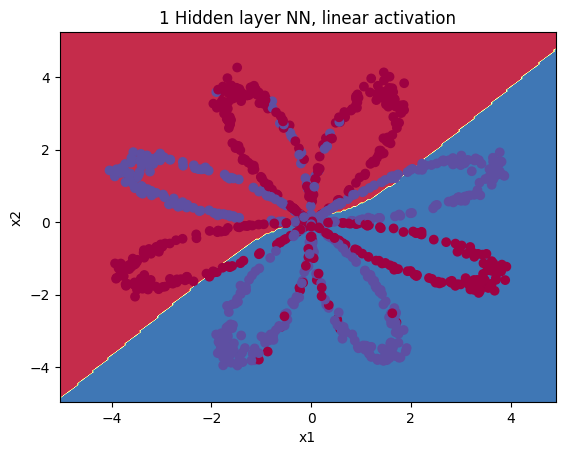

In [61]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

####  Use  the [hyperbolic tangent](https://mathworld.wolfram.com/HyperbolicTangent.html) activation `'tanh'` with the first simple model and compare the results with the sigmoid activation

In [63]:
model = keras.Sequential()
## The first layer need to have the input_shape
## change the activation function
model.add(layers.Dense(3, input_shape=(2,), activation= 'tanh'))
# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [64]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 [==============================] - 3s 11ms/step - loss: 0.6287 - accuracy: 0.6225 - val_loss: 0.6187 - val_accuracy: 0.6150
Epoch 2/25
100/100 [==============================] - 1s 6ms/step - loss: 0.6009 - accuracy: 0.6431 - val_loss: 0.5919 - val_accuracy: 0.6488
Epoch 3/25
100/100 [==============================] - 1s 8ms/step - loss: 0.5785 - accuracy: 0.6631 - val_loss: 0.5702 - val_accuracy: 0.6637
Epoch 4/25
100/100 [==============================] - 0s 3ms/step - loss: 0.5590 - accuracy: 0.6766 - val_loss: 0.5509 - val_accuracy: 0.6725
Epoch 5/25
100/100 [==============================] - 0s 2ms/step - loss: 0.5414 - accuracy: 0.6856 - val_loss: 0.5335 - val_accuracy: 0.6775
Epoch 6/25
100/100 [==============================] - 0s 3ms/step - loss: 0.5250 - accuracy: 0.7556 - val_loss: 0.5173 - val_accuracy: 0.7862
Epoch 7/25
100/100 [==============================] - 0s 2ms/step - loss: 0.5096 - accuracy: 0.8206 - val_loss: 0.5022 - val_accuracy: 0.8163
Epoch

Test Loss: 0.35945776104927063
Test Accuracy: 0.8960000276565552
1282/1282 [==============================] - 2s 1ms/step


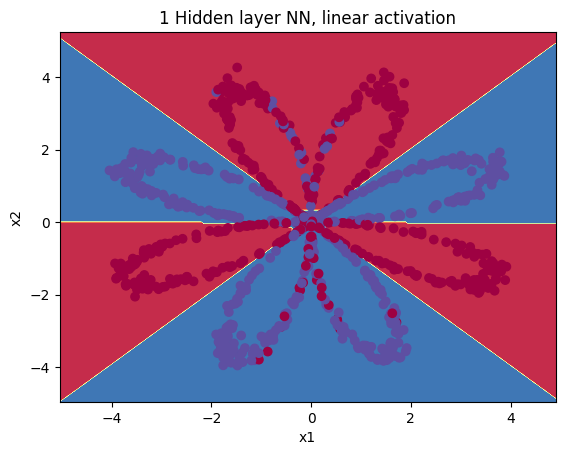

In [65]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

## Practice I

Repeat the process with a different dataset.

In [ ]:
N = 5000
X, y = sklearn.datasets.make_moons(n_samples=N, noise=.18)

In [ ]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.25,
)
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

### Define your model

In [ ]:
model = keras.Sequential()
## The first layer need to have the input_shape
model.add(layers...(..., input_shape=(...,), activation=...))

## Second Layer, don't use input_shape
model...(...)

# output layer
model.add(layers.Dense(..., activation=...))

In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=35, validation_split=0.2, batch_size=64)

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)

## Functional API

The Keras Functional API allows defining the topology of the models as a [acyclic directed graph](https://en.wikipedia.org/wiki/Directed_acyclic_graph) of layers. Next we will build the same model as in the previous section but using the Keras Functional API.

You need to start with an input data entry:
```python    
    inputs = keras.Input(shape=(8,))
```
    
We define the layers that we will include in the network and the relationships between them. It is important to note that each line details the type of layer and its properties (number of neurons, activation function, name ...) and just at the end, in parentheses, the name of the variable in which we have saved the layer from which its output will connect to the input of the layer we are declaring.
```python
layer_1 = layers.Dense(4, activation='sigmoid',
                       name='layer_1')(inputs)
layer_2 = layers.Dense(4, activation='sigmoid',
                       name='layer_2')(layer_1)
```

The "layer call" `Dense()(inputs)` action is like drawing an arrow from "inputs" to this layer you created. You're "passing" the inputs to the dense layer, and you get `layer_1` as the output.

  

Finally, we define the network outputs:
```python
outputs = layers.Dense(1, name='output_layer')(layer_2)
```

We create the model specifying the inputs and outputs:
```python
model = keras.Model(inputs=inputs, outputs=outputs)
```

In [ ]:
draw_neural_net(.1, .9, .1, .9, [8, 4, 4, 1])

In [ ]:
inputs = keras.Input(shape=(8, ), name='input_layer')
l_1 = layers.Dense(4, activation='relu', name='layer_1')(inputs)
l_2 = layers.Dense(4, activation='relu', name='layer_2')(l_1)
outputs = layers.Dense(1, name='output_layer')(l_2)

model = keras.Model(inputs=inputs, outputs=outputs, name='example_model')

model.summary()

In [ ]:
plot_model(model, show_shapes=True)

## Practice II

Repeat the process with a different dataset and the **Functional API**

In [ ]:
N = 5000
X, y = sklearn.datasets.make_circles(n_samples=N, factor=.65, noise=.065) # sklearn.datasets.make_moons(n_samples=N, noise=.15)

In [ ]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.25,
)
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

### Define your model

In [ ]:
inputs = keras.Input(shape=(2, ), name='input_layer')
## First hidden layer
l_1 = layers.Dense(...)(inputs)
...

## output layer
outputs = layers.Dense(...


model = keras.Model(inputs=inputs,...

In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=35, validation_split=0.2, batch_size=64)

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)

## Visualize decision boundary by epoch

In [ ]:
from sklearn.preprocessing import StandardScaler
from IPython.display import Image
import os

In [ ]:
def plot_save_decision_boundary(model, X, y, epoch, epoch_image):
    h = 0.1
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    X_grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(X_grid)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.5, colors=['blue', 'red'], levels=[-0.5, 0.5, 1.5])
    plt.scatter(X[y[:, 0] == 0][:, 0], X[y[:, 0] == 0][:, 1], color='blue', label='Class 0', alpha=0.5)
    plt.scatter(X[y[:, 0] == 1][:, 0], X[y[:, 0] == 1][:, 1], color='red', label='Class 1', alpha=0.5)
    plt.title(f'Epoch {epoch}')
    plt.savefig(epoch_image)
    plt.close()

def generate_spiral_dataset(n_points, noise=0.5):
    n = np.sqrt(np.random.rand(n_points, 1)) * 780 * (2 * np.pi) / 360
    d1x = -np.cos(n) * n + np.random.rand(n_points, 1) * noise
    d1y = np.sin(n) * n + np.random.rand(n_points, 1) * noise

    X, y = (np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x, -d1y)))),
            np.hstack((np.zeros(n_points), np.ones(n_points))))
    return X, y.reshape(-1, 1)

n_points = 2500
X, y = generate_spiral_dataset(n_points)

In [ ]:
plt.scatter(X[y[:, 0] == 0][:, 0], X[y[:, 0] == 0][:, 1], color='blue', label='Class 0')
plt.scatter(X[y[:, 0] == 1][:, 0], X[y[:, 0] == 1][:, 1], color='red', label='Class 1')
plt.legend()
plt.show()

In [ ]:
# Normalize data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

n_epochs = 60
epoch_images = []

for epoch in range(n_epochs):
    model.fit(X_train, y_train, epochs=1, verbose=0)
    epoch_image = f'epoch_{epoch}.png'
    epoch_images.append(epoch_image)

    plot_save_decision_boundary(model, X_test, y_test, epoch, epoch_image)

In [ ]:
from PIL import Image as Image_PIL

# Create the GIF
gif_filename = 'epoch_animation.gif'
images = [Image_PIL.open(epoch_image) for epoch_image in epoch_images]

duration = 0.15
images[0].save(gif_filename,
            format='GIF',
            append_images=images[1:],
            save_all=True,
            duration=duration*1000,
            loop=0)

# Delete the individual epoch images
for epoch_image in epoch_images:
    os.remove(epoch_image)

In [ ]:
# Display the GIF
Image(filename=gif_filename)